# Training the model
**Table of Contents**
1. [Setup](#1-setup)
2. [Dataset Preparation](#2-dataset-preparation)
3. [Training Loop](#3-training-loop)


## 1. Setup

In [1]:
# Automatic reloading
%load_ext autoreload
%autoreload 2

In [2]:
####################
# Required Modules #
####################

# Generic/Built-in
import random
import sys 
import os

# Libs
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from torch.utils.data import DataLoader

In [3]:
# Add the project root directory to the system path to enable imports from the '/src' folder.

# Get the project directory 
current_dir = os.path.abspath('') # Current '\notebooks' directory
project_dir = os.path.abspath(os.path.join(current_dir, '..')) # Move up one level to project root directory

# Add the project directory to sys.path
sys.path.append(project_dir)

# Move up to project directory
os.chdir(project_dir)
os.getcwd()

# Import custom modules
from src.data_preparation import *
from src.models import *
from src.train_eval import *
from src.utils import *

c:\Users\Ryan Lee\.conda\envs\term6\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Seeding
SEED = 42

# To be safe, seed all modules for full reproducibility
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)  # If using CUDA
np.random.seed(SEED)
random.seed(SEED)

## 2. Dataset Preparation

In [5]:
# Dataset Hyperparameters
sequence_size = 250 
stride = 125
num_train = 32
num_val = 4
num_test = 4

In [6]:
train_dataset, val_dataset, test_dataset = prepare_datasets(
    sequence_size=sequence_size, 
    stride=stride,
    num_train=num_train,
    num_val=num_val,
    num_test=num_test,
    random_state=SEED, # For reproducibility
    load_if_exists=True
)

🔄 Preparing dataset: Sequence Size: 250, Stride: 125, Gap Threshold: 0.1
📂 HARTH dataset already downloaded: data\harth.zip
📂 HARTH dataset already extracted in data\harth
📂 HAR70+ dataset already downloaded: data\har70.zip
📂 HAR70+ dataset already extracted in data\har70plus
✅ Successfully loaded recorded data of subjects from HARTH and HAR70+ datasets.
✅ HARDataset objects saved to dataset_cache
✅ Created train, validation, and test dataset objects.


In [7]:
print(f"Train Set: {len(train_dataset)} samples")
print(f"Validation Set: {len(val_dataset)} samples")
print(f"Test Set: {len(test_dataset)} samples")
print(f"Total: {len(train_dataset) + len(val_dataset) + len(train_dataset)} samples")

Train Set: 46215 samples
Validation Set: 11117 samples
Test Set: 9511 samples
Total: 103547 samples


## 3. Training Loop

In [8]:
# Hyperparameters
batch_size = 256
learning_rate = 0.001
num_epochs = 15 # 40
weight_decay = 1e-5 # L2 Regularization coefficient

In [9]:
# Dataloaders
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
validation_dataloader = DataLoader(val_dataset, batch_size = batch_size, shuffle = True)
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle = True)

Load the model in the cell below. There are 4 model architectures to choose from: `HarLSTM`, `HarGRU`, `HarTransformer`, and `HarTransformerExperimental`. The default parameter values should suffice.

In [10]:
# Load model
model_kwargs = {}
model = HarTransformerExperimental(**model_kwargs)

In [11]:
# Training optimizer
optimizer = torch.optim.Adam(
    model.parameters(), 
    lr = learning_rate,
    weight_decay=weight_decay
)

In [12]:
# Optional: Continue training by loading trained parameters
trained_params_path = "models/HarTransformerExperimental_2025-04-15_16-28-09/HarTransformerExperimental_best_F1.pth" # Specify path to .pth file here
# model.load_state_dict(torch.load(trained_params_path))

In [13]:
training_loss_history, validation_loss_history, micro_accuracy_history, macro_accuracy_history, f1_history, precision_history, recall_history, normalizer = train_HAR70_model(
    model, 
    optimizer, 
    train_dataloader, 
    validation_dataloader, 
    num_epochs = num_epochs
)

Beginning training session...
Model moved to cuda
(1) Creating subdirectory (models\HarTransformerExperimental_2025-04-17_20-20-55) for saving model params...
(2) Computing normalization statistics from the training dataset...
(3) Beginning training loop (15 epochs)...
Epoch [1/15] | Time: 28.61s
(Training) Loss: 0.5148
(Validation) Loss: 0.3551, Accuracy (micro): 0.8911, Accuracy (macro): 0.4544, F1: 0.4254, Precision: 0.4022, Recall: 0.4544
✅ Model saved: models\HarTransformerExperimental_2025-04-17_20-20-55\Best_F1.pth
✅ Model saved: models\HarTransformerExperimental_2025-04-17_20-20-55\Best_Macro_Accuracy.pth
Epoch [2/15] | Time: 20.30s
(Training) Loss: 0.2235
(Validation) Loss: 0.3481, Accuracy (micro): 0.8939, Accuracy (macro): 0.5388, F1: 0.5010, Precision: 0.5529, Recall: 0.5388
✅ Model saved: models\HarTransformerExperimental_2025-04-17_20-20-55\Best_F1.pth
✅ Model saved: models\HarTransformerExperimental_2025-04-17_20-20-55\Best_Macro_Accuracy.pth
Epoch [3/15] | Time: 20.48s


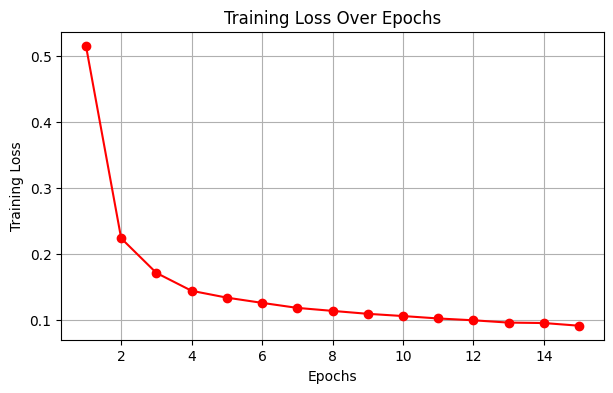

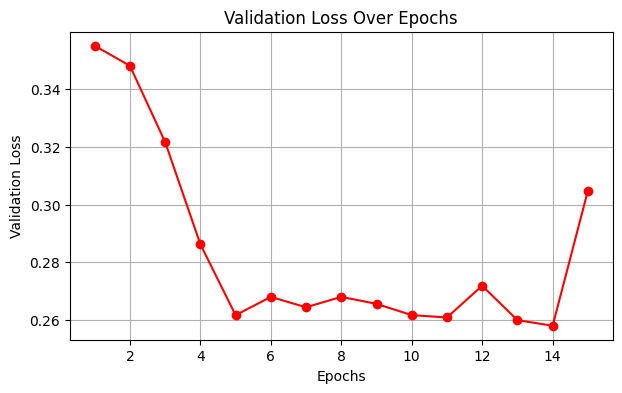

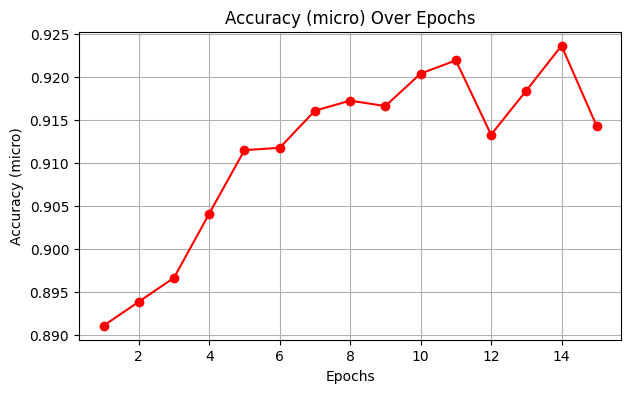

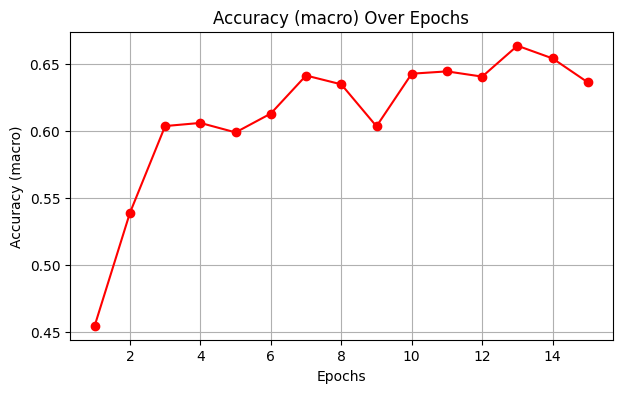

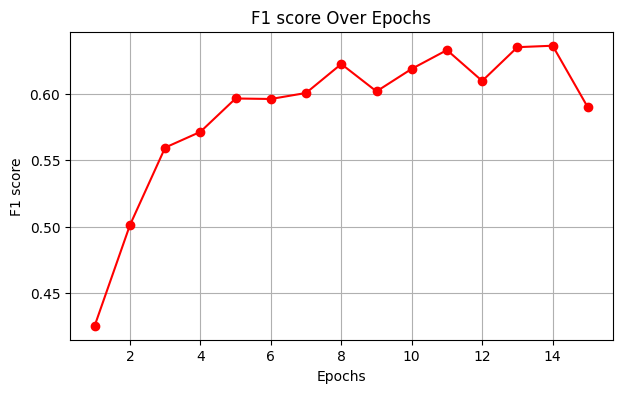

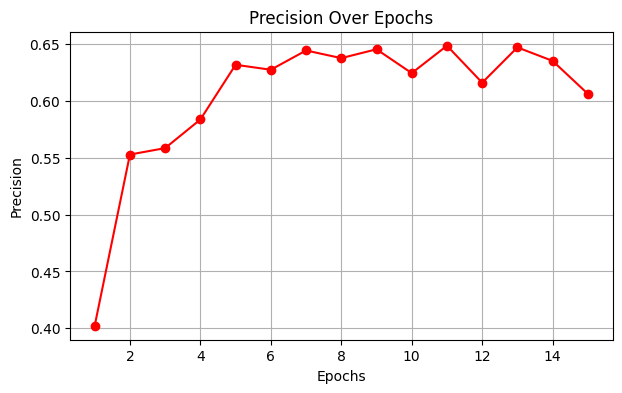

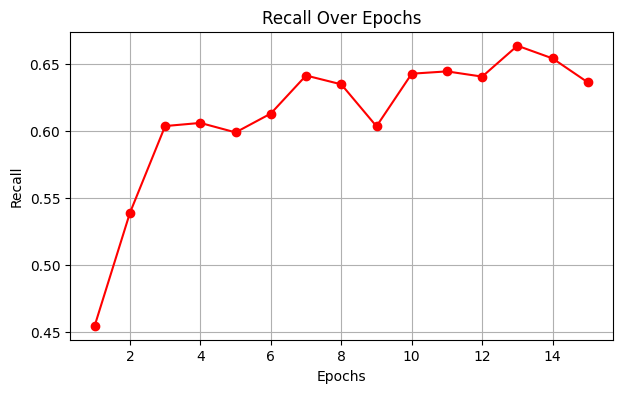

✅ Plots saved to: results\HarTransformerExperimental_2025-04-17_20-26-21
✅ Metric histories saved to: results\HarTransformerExperimental_2025-04-17_20-26-21\metric_histories.pth


In [14]:
save_dir = save_training_plots_and_metric_history(
    training_loss_history, validation_loss_history, micro_accuracy_history, macro_accuracy_history,
    f1_history, precision_history, recall_history, type(model).__name__
)

## 4. Test

In [15]:
# Test metrics
loss, micro_accuracy, macro_accuracy, f1, precision, recall, conf_matrix = evaluate_HAR70_model(model, test_dataloader, normalizer)
print(f"(Test) Loss: {loss:.4f}, Accuracy (micro): {micro_accuracy:.4f}, Accuracy (macro): {macro_accuracy:.4f}, F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

(Test) Loss: 0.2738, Accuracy (micro): 0.9287, Accuracy (macro): 0.7007, F1: 0.7001, Precision: 0.8147, Recall: 0.7007


In [33]:
matrix_name = "conf_matrix"

# Compute and save metric results
metric_results = save_confusion_matrix_and_metrics(
    save_dir=save_dir,
    conf_matrix_unnormalized=conf_matrix,
    file_name=matrix_name
)
metric_results

✅ Confusion Matrix saved to: results\HarTransformerExperimental_2025-04-17_20-26-21\conf_matrix.npy
✅ Confusion Matrix Metrics saved to: results\HarTransformerExperimental_2025-04-17_20-26-21\conf_matrix_metrics.txt


{'micro_accuracy': 0.9287141204920618,
 'macro_accuracy': 0.7006628083695573,
 'precision': 0.8146902128990975,
 'recall': 0.7006628083695573,
 'f1': 0.7000521184305724}

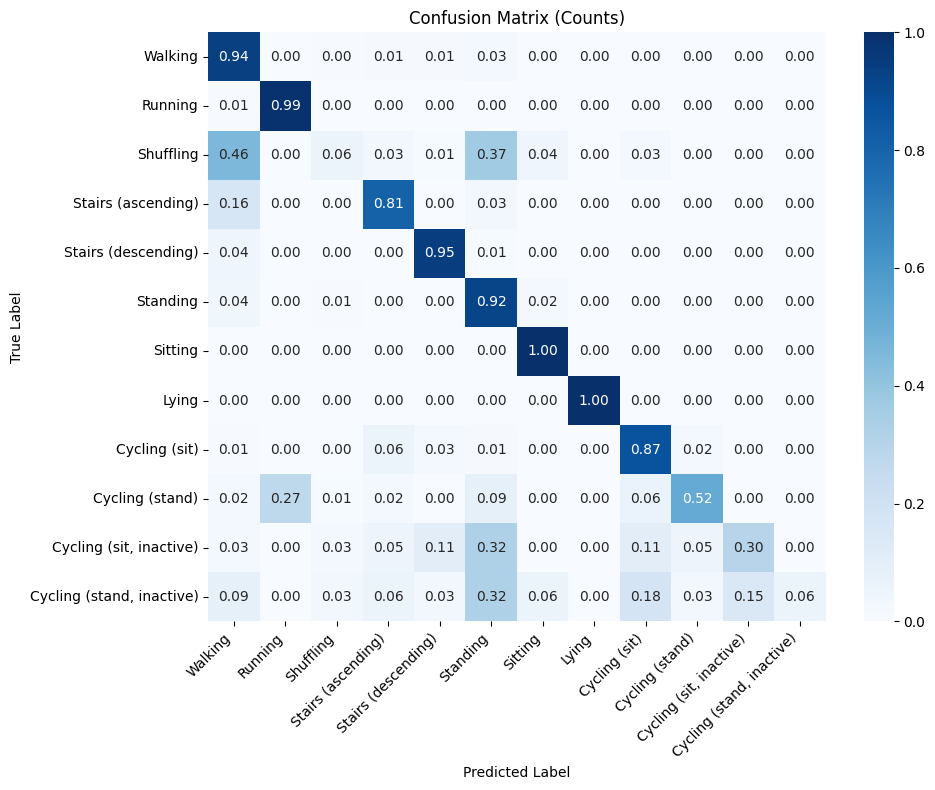

✅ Confusion Matrix Visualization saved to: results\HarTransformerExperimental_2025-04-17_20-26-21\conf_matrix.png


In [34]:
# Normalize confusion matrix (row-wise)
conf_matrix_normalized = normalize_confusion_matrix(conf_matrix)

# Original label mapping (12)
class_names = [
    "Walking", # Label 0
    "Running",
    "Shuffling",
    "Stairs (ascending)",
    "Stairs (descending)",
    "Standing",
    "Sitting",
    "Lying",
    "Cycling (sit)",
    "Cycling (stand)",
    "Cycling (sit, inactive)",
    "Cycling (stand, inactive)" # Label 11
]

# Plot confusion matrix
plot_and_save_confusion_matrix(
    save_dir=save_dir,
    conf_matrix=conf_matrix_normalized,
    file_name=matrix_name,
    class_names=class_names
)

Merge/ignore classes to address class imbalance and for comparison with HAR70+ paper results (which does the same thing).

In [35]:
print(list(enumerate(class_names)))

[(0, 'Walking'), (1, 'Running'), (2, 'Shuffling'), (3, 'Stairs (ascending)'), (4, 'Stairs (descending)'), (5, 'Standing'), (6, 'Sitting'), (7, 'Lying'), (8, 'Cycling (sit)'), (9, 'Cycling (stand)'), (10, 'Cycling (sit, inactive)'), (11, 'Cycling (stand, inactive)')]


In [36]:
merge_groups = [
    [8, 10], # Cycling (sit) + Cycling (sit, inactive)
    [9, 11], # Cycling (stand) + Cycling (stand, inactive)
]
merge_names = [
    "Cycling (sit)",
    "Cycling (stand)"
]

updated_conf_matrix, updated_class_names = merge_multiple_classes(
    conf_matrix=conf_matrix,
    class_names=class_names,
    merge_groups=merge_groups,
    merge_names=merge_names
)
updated_class_names

['Cycling (sit)',
 'Cycling (stand)',
 'Walking',
 'Running',
 'Shuffling',
 'Stairs (ascending)',
 'Stairs (descending)',
 'Standing',
 'Sitting',
 'Lying']

In [37]:
matrix_name = "updated_conf_matrix_1"

# Compute and save metric results
metric_results = save_confusion_matrix_and_metrics(
    save_dir=save_dir,
    conf_matrix_unnormalized=updated_conf_matrix,
    file_name=matrix_name
)
metric_results

✅ Confusion Matrix saved to: results\HarTransformerExperimental_2025-04-17_20-26-21\updated_conf_matrix_1.npy
✅ Confusion Matrix Metrics saved to: results\HarTransformerExperimental_2025-04-17_20-26-21\updated_conf_matrix_1_metrics.txt


{'micro_accuracy': 0.929450110398486,
 'macro_accuracy': 0.7933374604249084,
 'precision': 0.8182119398864998,
 'recall': 0.7933374604249084,
 'f1': 0.7804339079832496}

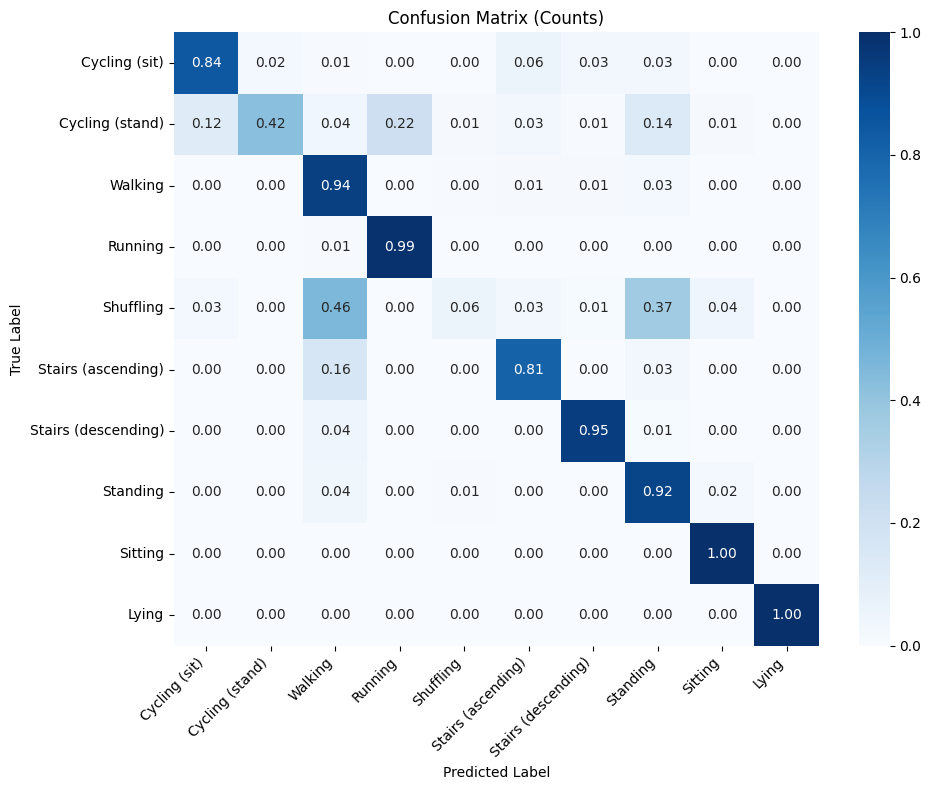

✅ Confusion Matrix Visualization saved to: results\HarTransformerExperimental_2025-04-17_20-26-21\updated_conf_matrix_1.png


In [38]:
# Normalize updated confusion matrix
updated_conf_matrix_normalized = normalize_confusion_matrix(updated_conf_matrix)

# Plot normalized confusion matrix
plot_and_save_confusion_matrix(
    save_dir=save_dir,
    conf_matrix=updated_conf_matrix_normalized,
    file_name=matrix_name,
    class_names=updated_class_names
)

Merge further:

In [39]:
print(list(enumerate(updated_class_names)))

[(0, 'Cycling (sit)'), (1, 'Cycling (stand)'), (2, 'Walking'), (3, 'Running'), (4, 'Shuffling'), (5, 'Stairs (ascending)'), (6, 'Stairs (descending)'), (7, 'Standing'), (8, 'Sitting'), (9, 'Lying')]


In [40]:
updated_conf_matrix, updated_class_names = ignore_classes(
    conf_matrix=updated_conf_matrix,
    class_names=updated_class_names,
    ignore_indices=[0,1,3] # Ignore Cycling (sit), Cycling (stand), Running
)
updated_class_names

['Walking',
 'Shuffling',
 'Stairs (ascending)',
 'Stairs (descending)',
 'Standing',
 'Sitting',
 'Lying']

In [41]:
# Merge
merge_groups = [
    [0, 2, 3], # Walking + Stairs (ascending) + Stairs (descending)
    [1, 4], # Shuffling + Standing
]
merge_names = [
    "Walking (merged)", 
    "Standing (merged)"
]
updated_conf_matrix, updated_class_names = merge_multiple_classes(
    conf_matrix=updated_conf_matrix,
    merge_groups=merge_groups,
    merge_names=merge_names,
    class_names=updated_class_names
)
updated_class_names

['Walking (merged)', 'Standing (merged)', 'Sitting', 'Lying']

In [42]:
matrix_name = "updated_conf_matrix_2"

# Compute and save metric results
metric_results = save_confusion_matrix_and_metrics(
    save_dir=save_dir,
    conf_matrix_unnormalized=updated_conf_matrix,
    file_name=matrix_name
)
metric_results

✅ Confusion Matrix saved to: results\HarTransformerExperimental_2025-04-17_20-26-21\updated_conf_matrix_2.npy
✅ Confusion Matrix Metrics saved to: results\HarTransformerExperimental_2025-04-17_20-26-21\updated_conf_matrix_2_metrics.txt


{'micro_accuracy': 0.9649843033083796,
 'macro_accuracy': 0.9540487483403433,
 'precision': 0.9634153636001003,
 'recall': 0.9540487483403433,
 'f1': 0.9575915922900342}

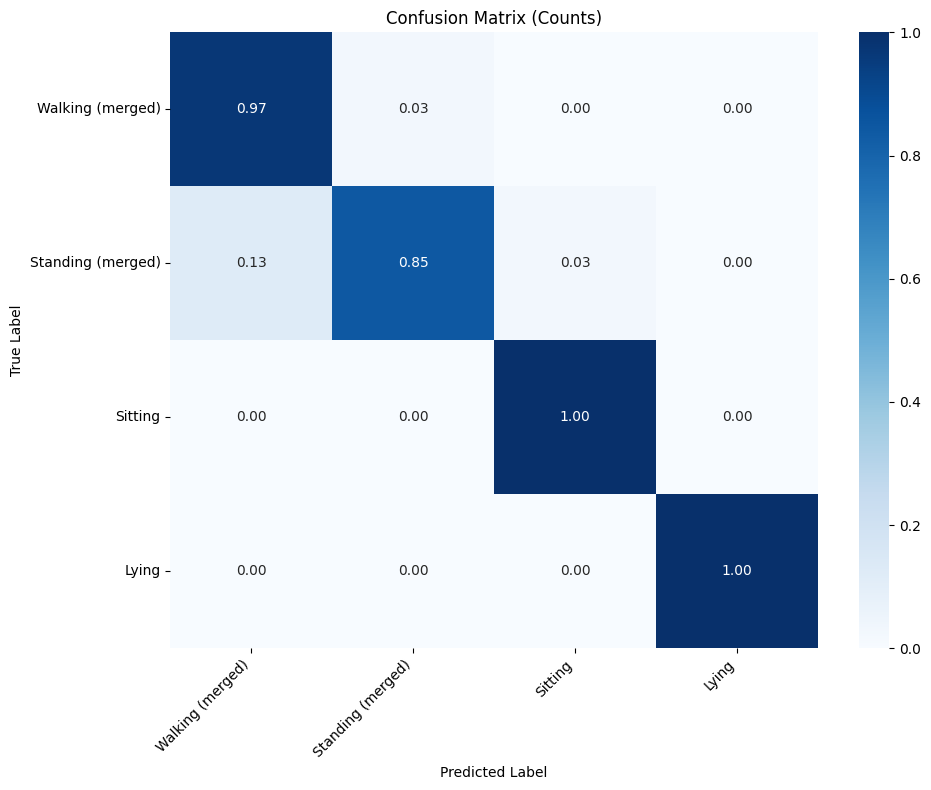

✅ Confusion Matrix Visualization saved to: results\HarTransformerExperimental_2025-04-17_20-26-21\updated_conf_matrix_2.png


In [43]:
# Normalize confusion matrix (row-wise)
updated_conf_matrix_normalized = normalize_confusion_matrix(updated_conf_matrix)

# Plot confusion matrix
plot_and_save_confusion_matrix(
    save_dir=save_dir,
    conf_matrix=updated_conf_matrix_normalized,
    file_name=matrix_name,
    class_names=updated_class_names
)

In [44]:
# Save session information
save_model_information(
    # Dataset Config:
    save_dir=save_dir, 
    sequence_size=sequence_size, 
    stride=stride, 
    num_train=num_train, 
    num_val=num_val, 
    num_test=num_test, 
    random_state=SEED,
    # Training Hyperparams:
    optimizer_name=type(optimizer).__name__,
    batch_size=batch_size,
    learning_rate=learning_rate,
    num_epochs=num_epochs,
    weight_decay=weight_decay,
    # Model Hyperparams:
    model_kwargs=model_kwargs,
    # Test Results:
    loss=loss,
    micro_accuracy=micro_accuracy,
    macro_accuracy=macro_accuracy,
    f1=f1,
    precision=precision,
    recall=recall
)

✅ Saved variable information to results\HarTransformerExperimental_2025-04-17_20-26-21\model_info.txt
